# O2 – Evaluation of CIFAR-100 Baseline CNN

Ce notebook :
- charge un modèle CNN entraîné sur CIFAR-100,
- calcule l'accuracy sur le jeu de test,
- affiche quelques exemples avec la prédiction et le label réel.


In [34]:
from pathlib import Path
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np


In [35]:
# CWD = notebooks/
cwd = Path.cwd()
print("CWD:", cwd)

# Racine du projet = parent de notebooks/
project_root = cwd.parent
print("Project root:", project_root)

# Ajouter la racine du projet au sys.path pour importer src.*
sys.path.append(str(project_root))
print("sys.path ajouté:", project_root)


CWD: c:\Users\ADMIN\Desktop\Deep_Learning_Dev\cifar100_project\notebooks
Project root: c:\Users\ADMIN\Desktop\Deep_Learning_Dev\cifar100_project
sys.path ajouté: c:\Users\ADMIN\Desktop\Deep_Learning_Dev\cifar100_project


In [36]:
from src.models.baseline_cnn import CIFAR100BaselineCNN
from src.utils.dataset_utils import get_dataloaders

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [37]:
from src.models.baseline_cnn import CIFAR100BaselineCNN
  # grâce à sys.path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [38]:
def load_model_from_checkpoint(ckpt_path: Path) -> torch.nn.Module:
    print(f"Loading checkpoint from: {ckpt_path}")
    state_dict = torch.load(ckpt_path, map_location=device)

    model = CIFAR100BaselineCNN().to(device)
    model.load_state_dict(state_dict)
    model.eval()
    return model


In [39]:
ckpt_dir = project_root / "checkpoints"

ckpt_local = ckpt_dir / "cifar100_baseline_best.pt"   # adapte le nom exact
ckpt_colab = ckpt_dir / "cifar100_colab_best.pt"   # adapte ici aussi

model_local = load_model_from_checkpoint(ckpt_local)
model_colab = load_model_from_checkpoint(ckpt_colab)


Loading checkpoint from: c:\Users\ADMIN\Desktop\Deep_Learning_Dev\cifar100_project\checkpoints\cifar100_baseline_best.pt
Loading checkpoint from: c:\Users\ADMIN\Desktop\Deep_Learning_Dev\cifar100_project\checkpoints\cifar100_colab_best.pt


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3152\2263379733.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location=device)


In [40]:
def evaluate(model, loader):
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100.0 * correct / total


In [41]:
train_loader, test_loader = get_dataloaders(
    data_dir=str(project_root / "data"),
    batch_size=128,
    num_workers=2
)

len(test_loader.dataset)


Files already downloaded and verified
Files already downloaded and verified


10000

In [42]:
acc_local = evaluate(model_local, test_loader)
acc_colab = evaluate(model_colab, test_loader)

print(f"Local model accuracy : {acc_local:.2f}%")
print(f"Colab  model accuracy : {acc_colab:.2f}%")
print(f"Gain Colab vs Local   : {acc_colab - acc_local:.2f} points")


Local model accuracy : 30.02%
Colab  model accuracy : 44.34%
Gain Colab vs Local   : 14.32 points


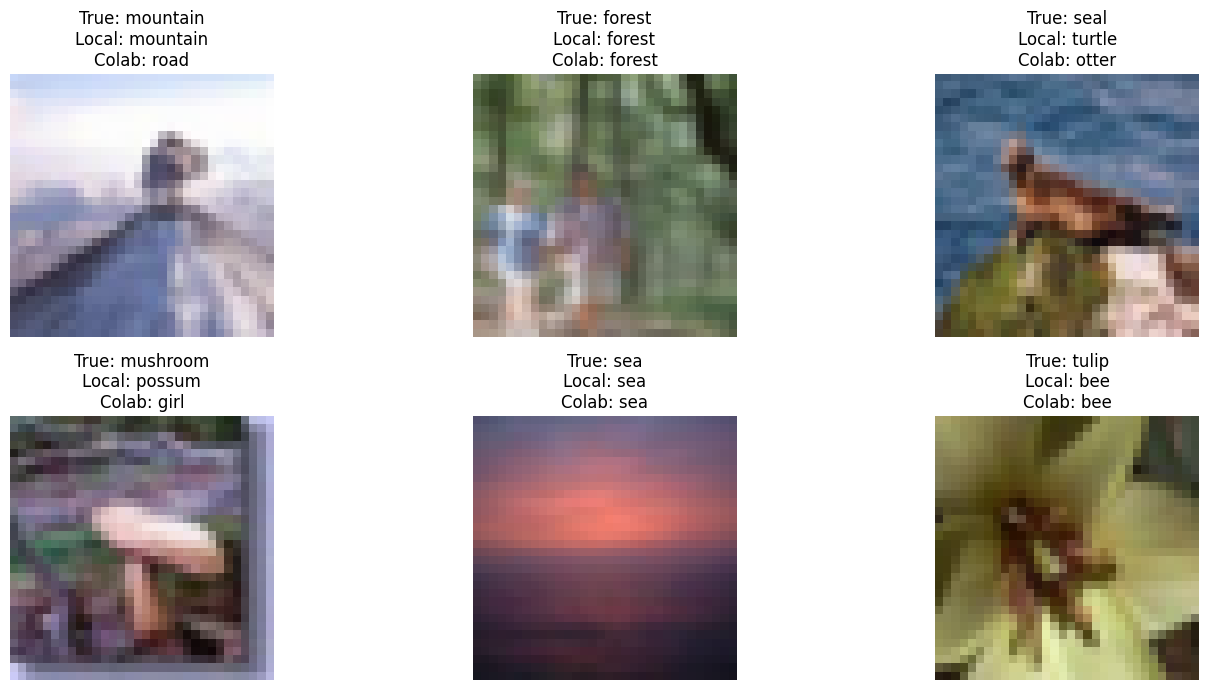

In [43]:
# Récupérer les classes
test_dataset = test_loader.dataset
classes = test_dataset.classes

def denormalize(img_tensor):
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])
    img = img_tensor.numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Un batch
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    logits_local = model_local(images)
    logits_colab = model_colab(images)

_, preds_local = torch.max(logits_local, 1)
_, preds_colab = torch.max(logits_colab, 1)

n = 6  # nombre d'images à afficher

plt.figure(figsize=(15, 7))
for i in range(n):
    plt.subplot(2, 3, i+1)
    img = denormalize(images[i].cpu())
    plt.imshow(img)
    true_label = classes[labels[i].item()]
    local_label = classes[preds_local[i].item()]
    colab_label = classes[preds_colab[i].item()]
    plt.title(
        f"True: {true_label}\nLocal: {local_label}\nColab: {colab_label}"
    )
    plt.axis("off")
plt.tight_layout()
plt.show()


In [44]:
checkpoint_path = project_root / "checkpoints" / "cifar100_baseline_best.pt"
print("Loading checkpoint from:", checkpoint_path)

state_dict = torch.load(checkpoint_path, map_location=device)

model = CIFAR100BaselineCNN().to(device)
model.load_state_dict(state_dict)
model.eval()

print("Model loaded ✅")


Loading checkpoint from: c:\Users\ADMIN\Desktop\Deep_Learning_Dev\cifar100_project\checkpoints\cifar100_baseline_best.pt
Model loaded ✅


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3152\819629964.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device)


In [45]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Test accuracy: {test_acc:.2f}%")


Test accuracy: 30.02%


Nombre de classes: 100
max label: 97 max pred: 98


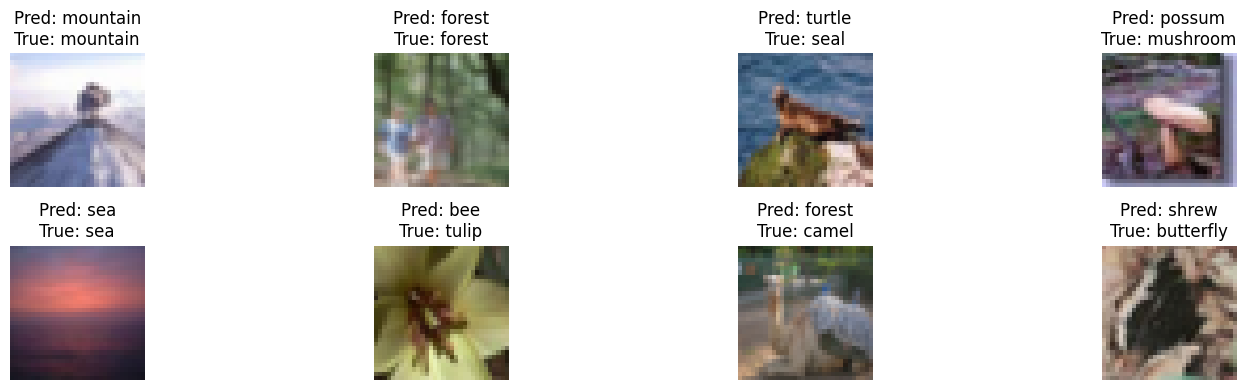

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# On récupère les classes directement du dataset utilisé par test_loader
test_dataset = test_loader.dataset
cifar100_classes = test_dataset.classes
print("Nombre de classes:", len(cifar100_classes))

def denormalize(img_tensor):
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])
    img = img_tensor.numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Un batch du test set
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

print("max label:", labels.max().item(), "max pred:", predicted.max().item())

n = 8  # nombre d'images à afficher
plt.figure(figsize=(16, 4))
for i in range(n):
    plt.subplot(2, 4, i+1)
    img = denormalize(images[i].cpu())
    plt.imshow(img)
    true_idx = labels[i].item()
    pred_idx = predicted[i].item()
    plt.title(
        f"Pred: {cifar100_classes[pred_idx]}\nTrue: {cifar100_classes[true_idx]}"
    )
    plt.axis("off")
plt.tight_layout()
plt.show()
